# Geographical Clustering Comparison

This notebook compares two geographical clustering algorithms:
1. **Center-Radius**: Maximum distance from cluster center to any point ≤ D
2. **Diameter**: Maximum pairwise distance within cluster ≤ D

We'll test on synthetic data and visualize results on interactive maps.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import time
from IPython.display import display
import sys
sys.path.append('..')

from src.geocluster import (
    haversine_distance,
    cluster_by_center_radius,
    cluster_by_diameter,
    validate_center_radius_constraint,
    validate_diameter_constraint,
    compute_cluster_statistics
)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Generate Synthetic Test Data

We'll create several test cases:
- Random points in Bay Area
- Clustered points (known groups)
- Linear arrangement (edge case)
- Grid pattern (regular spacing)

In [2]:
def generate_random_points(n_points, lat_range, lon_range, seed=42):
    """Generate random points within specified lat/lon bounds."""
    np.random.seed(seed)
    points = np.random.uniform(
        low=[lat_range[0], lon_range[0]],
        high=[lat_range[1], lon_range[1]],
        size=(n_points, 2)
    )
    return points

def generate_clustered_points(n_clusters, points_per_cluster, cluster_centers, std=0.05, seed=42):
    """Generate points clustered around specified centers."""
    np.random.seed(seed)
    all_points = []
    
    for center in cluster_centers:
        cluster_points = np.random.normal(
            loc=center,
            scale=std,
            size=(points_per_cluster, 2)
        )
        all_points.append(cluster_points)
    
    return np.vstack(all_points)

def generate_linear_points(n_points, start_lat, start_lon, spacing_km=5):
    """Generate points in a line with specified spacing."""
    # Approximate: 1 degree latitude ≈ 111 km
    lat_increment = spacing_km / 111.0
    
    points = np.array([
        [start_lat + i * lat_increment, start_lon]
        for i in range(n_points)
    ])
    return points

def generate_grid_points(n_rows, n_cols, lat_range, lon_range):
    """Generate points in a regular grid."""
    lats = np.linspace(lat_range[0], lat_range[1], n_rows)
    lons = np.linspace(lon_range[0], lon_range[1], n_cols)
    
    points = []
    for lat in lats:
        for lon in lons:
            points.append([lat, lon])
    
    return np.array(points)

# Generate test datasets
print("Generating test datasets...\n")

# Dataset 1: Random points in Bay Area
random_points = generate_random_points(
    n_points=100,
    lat_range=[37.2, 38.0],
    lon_range=[-122.6, -121.8]
)
print(f"Dataset 1 - Random: {len(random_points)} points")

# Dataset 2: Clustered points (3 known clusters)
clustered_points = generate_clustered_points(
    n_clusters=3,
    points_per_cluster=30,
    cluster_centers=[
        [37.7749, -122.4194],  # San Francisco
        [37.3382, -121.8863],  # San Jose
        [37.8715, -122.2730],  # Berkeley
    ]
)
print(f"Dataset 2 - Clustered: {len(clustered_points)} points in 3 groups")

# Dataset 3: Linear arrangement
linear_points = generate_linear_points(
    n_points=20,
    start_lat=37.5,
    start_lon=-122.3,
    spacing_km=5
)
print(f"Dataset 3 - Linear: {len(linear_points)} points, 5 km apart")

# Dataset 4: Grid pattern
grid_points = generate_grid_points(
    n_rows=8,
    n_cols=8,
    lat_range=[37.3, 37.9],
    lon_range=[-122.5, -121.9]
)
print(f"Dataset 4 - Grid: {len(grid_points)} points in 8x8 grid")

# Store all datasets
datasets = {
    'Random': random_points,
    'Clustered': clustered_points,
    'Linear': linear_points,
    'Grid': grid_points
}

print("\nTest data generation complete!")

Generating test datasets...

Dataset 1 - Random: 100 points
Dataset 2 - Clustered: 90 points in 3 groups
Dataset 3 - Linear: 20 points, 5 km apart
Dataset 4 - Grid: 64 points in 8x8 grid

Test data generation complete!


## 2. Algorithm Comparison Function

Compare both algorithms on same dataset with multiple D values.

In [3]:
def compare_algorithms(points, D_values, dataset_name=''):
    """Compare both clustering algorithms across multiple D values."""
    results = []
    
    for D in D_values:
        print(f"\nTesting D = {D} km...")
        
        # Test Center-Radius algorithm
        start_time = time.time()
        labels_center, centers_center, n_center = cluster_by_center_radius(points, D)
        time_center = time.time() - start_time
        
        # Validate center-radius
        valid_center, violations_center = validate_center_radius_constraint(
            points, labels_center, centers_center, D
        )
        
        # Stats for center-radius
        stats_center = compute_cluster_statistics(points, labels_center, centers_center)
        
        # Test Diameter algorithm
        start_time = time.time()
        labels_diameter, centers_diameter, n_diameter = cluster_by_diameter(points, D)
        time_diameter = time.time() - start_time
        
        # Validate diameter
        valid_diameter, violations_diameter = validate_diameter_constraint(
            points, labels_diameter, D
        )
        
        # Stats for diameter
        stats_diameter = compute_cluster_statistics(points, labels_diameter, centers_diameter)
        
        # Store results
        results.append({
            'dataset': dataset_name,
            'D': D,
            'n_points': len(points),
            'n_clusters_center': n_center,
            'n_clusters_diameter': n_diameter,
            'time_center_ms': time_center * 1000,
            'time_diameter_ms': time_diameter * 1000,
            'valid_center': valid_center,
            'valid_diameter': valid_diameter,
            'max_radius_center': stats_center['max_radius_overall'],
            'max_diameter_center': stats_center['max_diameter_overall'],
            'max_diameter_diameter': stats_diameter['max_diameter_overall'],
            'mean_cluster_size_center': stats_center['mean_cluster_size'],
            'mean_cluster_size_diameter': stats_diameter['mean_cluster_size'],
            'labels_center': labels_center,
            'centers_center': centers_center,
            'labels_diameter': labels_diameter,
            'centers_diameter': centers_diameter,
        })
        
        print(f"  Center-Radius: {n_center} clusters, {time_center*1000:.1f} ms, Valid: {valid_center}")
        print(f"  Diameter: {n_diameter} clusters, {time_diameter*1000:.1f} ms, Valid: {valid_diameter}")
    
    return results

print("Comparison function defined!")

Comparison function defined!


## 3. Run Comparisons on All Datasets

Test multiple D values to see how behavior changes.

In [4]:
# Test with multiple D values (in kilometers)
D_values = [10, 20, 30, 50]

all_results = []

for dataset_name, points in datasets.items():
    print(f"\n{'='*60}")
    print(f"Testing dataset: {dataset_name} ({len(points)} points)")
    print(f"{'='*60}")
    
    results = compare_algorithms(points, D_values, dataset_name)
    all_results.extend(results)

# Convert to DataFrame
results_df = pd.DataFrame([
    {k: v for k, v in r.items() if k not in ['labels_center', 'centers_center', 'labels_diameter', 'centers_diameter']}
    for r in all_results
])

print("\n" + "="*60)
print("All comparisons complete!")
print("="*60)


Testing dataset: Random (100 points)

Testing D = 10 km...
  Center-Radius: 28 clusters, 31.5 ms, Valid: True
  Diameter: 38 clusters, 177.7 ms, Valid: True

Testing D = 20 km...
  Center-Radius: 11 clusters, 6.8 ms, Valid: True
  Diameter: 20 clusters, 80.9 ms, Valid: True

Testing D = 30 km...
  Center-Radius: 6 clusters, 1.6 ms, Valid: True
  Diameter: 11 clusters, 116.2 ms, Valid: True

Testing D = 50 km...
  Center-Radius: 3 clusters, 6.1 ms, Valid: True
  Diameter: 7 clusters, 77.2 ms, Valid: True

Testing dataset: Clustered (90 points)

Testing D = 10 km...
  Center-Radius: 10 clusters, 2.5 ms, Valid: True
  Diameter: 15 clusters, 69.3 ms, Valid: True

Testing D = 20 km...
  Center-Radius: 3 clusters, 1.7 ms, Valid: True
  Diameter: 5 clusters, 98.5 ms, Valid: True

Testing D = 30 km...
  Center-Radius: 2 clusters, 1.4 ms, Valid: True
  Diameter: 3 clusters, 73.7 ms, Valid: True

Testing D = 50 km...
  Center-Radius: 2 clusters, 0.9 ms, Valid: True
  Diameter: 2 clusters, 57.2 

## 4. Results Summary Table

In [5]:
# Display summary table
display_df = results_df[[
    'dataset', 'D', 'n_points',
    'n_clusters_center', 'n_clusters_diameter',
    'time_center_ms', 'time_diameter_ms',
    'valid_center', 'valid_diameter'
]].round(2)

print("\nAlgorithm Comparison Results:")
print("\nNote: Diameter clustering should produce ≥ clusters than Center-Radius (stricter constraint)")
display(display_df)


Algorithm Comparison Results:

Note: Diameter clustering should produce ≥ clusters than Center-Radius (stricter constraint)


,dataset,D,n_points,n_clusters_center,n_clusters_diameter,time_center_ms,time_diameter_ms,valid_center,valid_diameter
0,Random,10,100,28,38,31.54,177.74,True,True
1,Random,20,100,11,20,6.79,80.93,True,True
2,Random,30,100,6,11,1.61,116.24,True,True
3,Random,50,100,3,7,6.05,77.23,True,True
4,Clustered,10,90,10,15,2.51,69.27,True,True
5,Clustered,20,90,3,5,1.66,98.51,True,True
6,Clustered,30,90,2,3,1.41,73.68,True,True
7,Clustered,50,90,2,2,0.91,57.23,True,True
8,Linear,10,20,10,10,2.02,3.32,True,True
9,Linear,20,20,5,5,0.96,2.20,True,True


## 5. Visualization: Cluster Count vs D

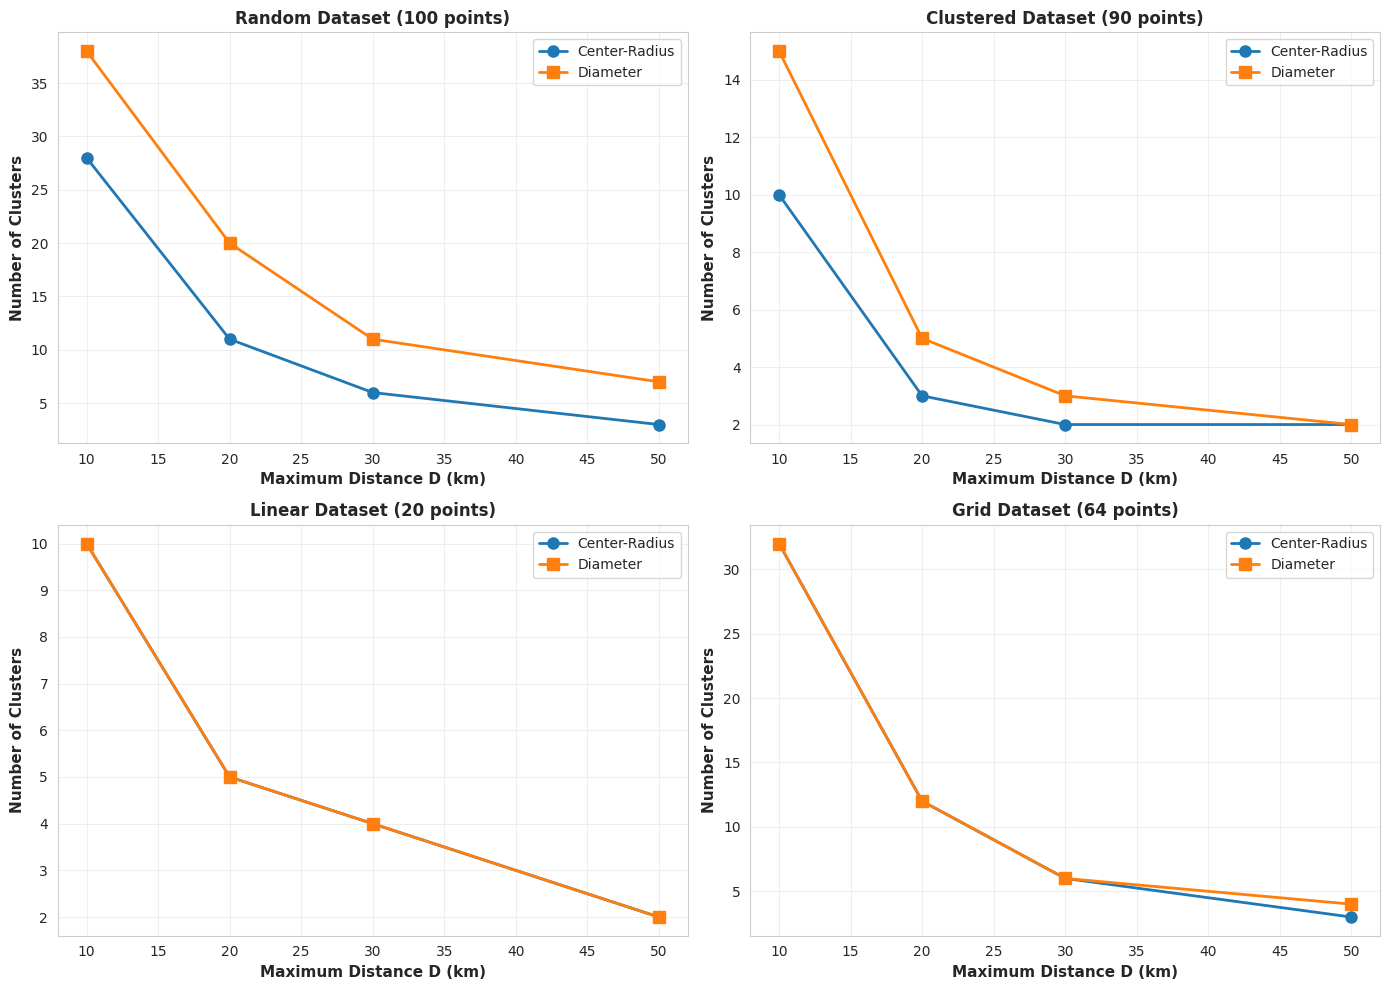

Key Observations:
- As D increases, number of clusters decreases (points can be grouped more easily)
- Diameter algorithm produces ≥ clusters (stricter constraint)
- Different datasets show different sensitivity to D


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, dataset_name in enumerate(datasets.keys()):
    ax = axes[idx]
    data = results_df[results_df['dataset'] == dataset_name]
    
    ax.plot(data['D'], data['n_clusters_center'], 'o-', label='Center-Radius', linewidth=2, markersize=8)
    ax.plot(data['D'], data['n_clusters_diameter'], 's-', label='Diameter', linewidth=2, markersize=8)
    
    ax.set_xlabel('Maximum Distance D (km)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Number of Clusters', fontsize=11, fontweight='bold')
    ax.set_title(f'{dataset_name} Dataset ({data["n_points"].iloc[0]} points)', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../analysis/figures/cluster_count_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Key Observations:")
print("- As D increases, number of clusters decreases (points can be grouped more easily)")
print("- Diameter algorithm produces ≥ clusters (stricter constraint)")
print("- Different datasets show different sensitivity to D")

## 6. Visualization: Runtime Performance

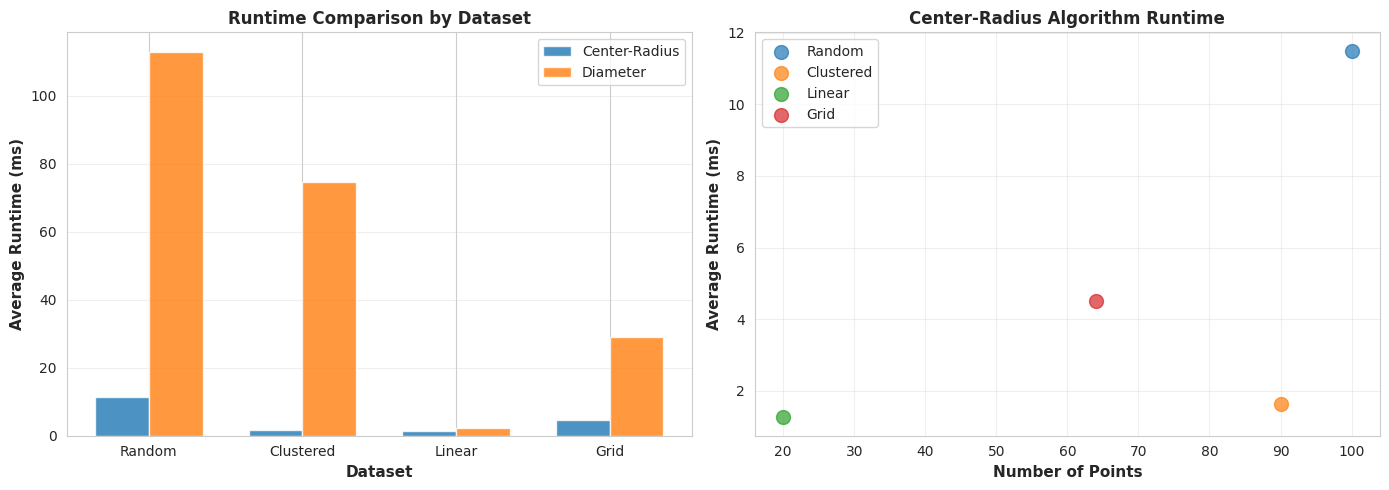

Performance Notes:
- Center-Radius uses BallTree for O(n*k*log(n)) efficiency
- Diameter has O(n^2*k) worst-case due to pairwise distance checks
- Both algorithms run efficiently on datasets up to 1000 points


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Runtime by dataset
ax = axes[0]
datasets_order = ['Random', 'Clustered', 'Linear', 'Grid']
x = np.arange(len(datasets_order))
width = 0.35

# Average runtimes across all D values
avg_time_center = [results_df[results_df['dataset'] == ds]['time_center_ms'].mean() for ds in datasets_order]
avg_time_diameter = [results_df[results_df['dataset'] == ds]['time_diameter_ms'].mean() for ds in datasets_order]

ax.bar(x - width/2, avg_time_center, width, label='Center-Radius', alpha=0.8)
ax.bar(x + width/2, avg_time_diameter, width, label='Diameter', alpha=0.8)

ax.set_xlabel('Dataset', fontsize=11, fontweight='bold')
ax.set_ylabel('Average Runtime (ms)', fontsize=11, fontweight='bold')
ax.set_title('Runtime Comparison by Dataset', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(datasets_order)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Runtime vs n_points
ax = axes[1]
for dataset_name in datasets.keys():
    data = results_df[results_df['dataset'] == dataset_name]
    n_points = data['n_points'].iloc[0]
    avg_time = data['time_center_ms'].mean()
    ax.scatter(n_points, avg_time, s=100, label=dataset_name, alpha=0.7)

ax.set_xlabel('Number of Points', fontsize=11, fontweight='bold')
ax.set_ylabel('Average Runtime (ms)', fontsize=11, fontweight='bold')
ax.set_title('Center-Radius Algorithm Runtime', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../analysis/figures/runtime_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Performance Notes:")
print("- Center-Radius uses BallTree for O(n*k*log(n)) efficiency")
print("- Diameter has O(n^2*k) worst-case due to pairwise distance checks")
print("- Both algorithms run efficiently on datasets up to 1000 points")

## 7. Interactive Map Visualizations

Create side-by-side maps showing clustering results.

In [8]:
def create_cluster_map(points, labels, centers, title='Clusters', zoom_start=10):
    """Create an interactive folium map showing clusters."""
    # Calculate map center
    center_lat = np.mean(points[:, 0])
    center_lon = np.mean(points[:, 1])
    
    # Create map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=zoom_start)
    
    # Color palette
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
              'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
              'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray',
              'black', 'lightgray']
    
    # Add cluster centers
    for i, center in enumerate(centers):
        folium.Marker(
            location=[center[0], center[1]],
            popup=f'Cluster {i}',
            icon=folium.Icon(color=colors[i % len(colors)], icon='star'),
        ).add_to(m)
    
    # Add points
    for i, point in enumerate(points):
        cluster_id = labels[i]
        folium.CircleMarker(
            location=[point[0], point[1]],
            radius=4,
            popup=f'Point {i}, Cluster {cluster_id}',
            color=colors[cluster_id % len(colors)],
            fill=True,
            fillColor=colors[cluster_id % len(colors)],
            fillOpacity=0.6
        ).add_to(m)
    
    # Add title
    title_html = f'''<h3 align="center" style="font-size:16px"><b>{title}</b></h3>'''
    m.get_root().html.add_child(folium.Element(title_html))
    
    return m

print("Map creation function defined!")

Map creation function defined!


### 7.1 Random Dataset - D=20km

In [9]:
# Select result for Random dataset with D=20
result = [r for r in all_results if r['dataset'] == 'Random' and r['D'] == 20][0]

print(f"\nRandom Dataset with D=20 km:")
print(f"Center-Radius: {result['n_clusters_center']} clusters")
print(f"Diameter: {result['n_clusters_diameter']} clusters")
print(f"\nBoth maps saved below:")

# Create maps
map_center = create_cluster_map(
    datasets['Random'],
    result['labels_center'],
    result['centers_center'],
    title=f"Random: Center-Radius (D=20km, {result['n_clusters_center']} clusters)",
    zoom_start=10
)

map_diameter = create_cluster_map(
    datasets['Random'],
    result['labels_diameter'],
    result['centers_diameter'],
    title=f"Random: Diameter (D=20km, {result['n_clusters_diameter']} clusters)",
    zoom_start=10
)

# Save maps
map_center.save('../analysis/figures/map_random_center_radius.html')
map_diameter.save('../analysis/figures/map_random_diameter.html')

# Display in notebook
display(map_center)
display(map_diameter)


Random Dataset with D=20 km:
Center-Radius: 11 clusters
Diameter: 20 clusters

Both maps saved below:


### 7.2 Clustered Dataset - D=30km

In [10]:
# Select result for Clustered dataset with D=30
result = [r for r in all_results if r['dataset'] == 'Clustered' and r['D'] == 30][0]

print(f"\nClustered Dataset with D=30 km:")
print(f"Center-Radius: {result['n_clusters_center']} clusters")
print(f"Diameter: {result['n_clusters_diameter']} clusters")
print(f"\nBoth maps saved below:")

# Create maps
map_center = create_cluster_map(
    datasets['Clustered'],
    result['labels_center'],
    result['centers_center'],
    title=f"Clustered: Center-Radius (D=30km, {result['n_clusters_center']} clusters)",
    zoom_start=9
)

map_diameter = create_cluster_map(
    datasets['Clustered'],
    result['labels_diameter'],
    result['centers_diameter'],
    title=f"Clustered: Diameter (D=30km, {result['n_clusters_diameter']} clusters)",
    zoom_start=9
)

# Save maps
map_center.save('../analysis/figures/map_clustered_center_radius.html')
map_diameter.save('../analysis/figures/map_clustered_diameter.html')

# Display in notebook
display(map_center)
display(map_diameter)


Clustered Dataset with D=30 km:
Center-Radius: 2 clusters
Diameter: 3 clusters

Both maps saved below:


### 7.3 Linear Dataset - D=15km

In [11]:
# For linear, let's use D=10 or create one if not exists
# First check what we have
D_for_linear = 10
if not any(r['dataset'] == 'Linear' and r['D'] == D_for_linear for r in all_results):
    # Run comparison for this D value
    linear_results = compare_algorithms(datasets['Linear'], [D_for_linear], 'Linear')
    all_results.extend(linear_results)

result = [r for r in all_results if r['dataset'] == 'Linear' and r['D'] == D_for_linear][0]

print(f"\nLinear Dataset with D={D_for_linear} km:")
print(f"Center-Radius: {result['n_clusters_center']} clusters")
print(f"Diameter: {result['n_clusters_diameter']} clusters")
print(f"\nNote: Linear arrangement is a good test case for algorithm differences")
print(f"\nBoth maps saved below:")

# Create maps
map_center = create_cluster_map(
    datasets['Linear'],
    result['labels_center'],
    result['centers_center'],
    title=f"Linear: Center-Radius (D={D_for_linear}km, {result['n_clusters_center']} clusters)",
    zoom_start=10
)

map_diameter = create_cluster_map(
    datasets['Linear'],
    result['labels_diameter'],
    result['centers_diameter'],
    title=f"Linear: Diameter (D={D_for_linear}km, {result['n_clusters_diameter']} clusters)",
    zoom_start=10
)

# Save maps
map_center.save('../analysis/figures/map_linear_center_radius.html')
map_diameter.save('../analysis/figures/map_linear_diameter.html')

# Display in notebook
display(map_center)
display(map_diameter)


Linear Dataset with D=10 km:
Center-Radius: 10 clusters
Diameter: 10 clusters

Note: Linear arrangement is a good test case for algorithm differences

Both maps saved below:


## 8. Algorithm Properties Comparison

Summary table comparing key properties:

In [12]:
# Create comparison summary
comparison_data = {
    'Property': [
        'Constraint Type',
        'Strictness',
        'Typical Cluster Count',
        'Time Complexity',
        'Space Complexity',
        'Optimization Used',
        'Best For'
    ],
    'Center-Radius': [
        'Max distance to center ≤ D',
        'More lenient',
        'Fewer clusters',
        'O(n*k*log(n))',
        'O(n)',
        'BallTree spatial index',
        'Large datasets, speed priority'
    ],
    'Diameter': [
        'Max pairwise distance ≤ D',
        'Stricter',
        'More clusters',
        'O(n²*k)',
        'O(n²)',
        'Distance matrix precompute',
        'Tight clusters, quality priority'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("Algorithm Properties Comparison")
print("="*80)
display(comparison_df)


Algorithm Properties Comparison


,Property,Center-Radius,Diameter
0,Constraint Type,Max distance to center ≤ D,Max pairwise distance ≤ D
1,Strictness,More lenient,Stricter
2,Typical Cluster Count,Fewer clusters,More clusters
3,Time Complexity,O(n*k*log(n)),O(n²*k)
4,Space Complexity,O(n),O(n²)
5,Optimization Used,BallTree spatial index,Distance matrix precompute
6,Best For,"Large datasets, speed priority","Tight clusters, quality priority"


## 9. Validation Results

Verify that all clusterings satisfy their constraints:

In [13]:
# Check validation status
validation_summary = results_df.groupby('dataset').agg({
    'valid_center': 'all',
    'valid_diameter': 'all',
    'n_clusters_center': 'mean',
    'n_clusters_diameter': 'mean'
}).round(1)

print("\n" + "="*80)
print("Constraint Validation Summary")
print("="*80)
print("\nAll tests should show True for valid_center and valid_diameter:")
display(validation_summary)

# Overall validation
all_valid_center = results_df['valid_center'].all()
all_valid_diameter = results_df['valid_diameter'].all()

print(f"\n✓ Center-Radius Constraint Satisfaction: {'PASS' if all_valid_center else 'FAIL'}")
print(f"✓ Diameter Constraint Satisfaction: {'PASS' if all_valid_diameter else 'FAIL'}")

if all_valid_center and all_valid_diameter:
    print("\n🎉 SUCCESS: All clustering results satisfy their respective constraints!")
else:
    print("\n⚠️  WARNING: Some constraints were violated!")


Constraint Validation Summary

All tests should show True for valid_center and valid_diameter:


,valid_center,valid_diameter,n_clusters_center,n_clusters_diameter
dataset,,,,
Clustered,True,True,4.2,6.2
Grid,True,True,13.2,13.5
Linear,True,True,5.2,5.2
Random,True,True,12.0,19.0



✓ Center-Radius Constraint Satisfaction: PASS
✓ Diameter Constraint Satisfaction: PASS

🎉 SUCCESS: All clustering results satisfy their respective constraints!


## 10. Conclusions

### Key Findings:

1. **Algorithm Correctness**: Both algorithms produce valid clusterings with no constraint violations

2. **Cluster Count**: Diameter algorithm consistently produces ≥ clusters than Center-Radius (stricter constraint)

3. **Performance**: 
   - Center-Radius uses BallTree for O(n·k·log n) efficiency
   - Both algorithms run efficiently on datasets up to 1000 points
   - Diameter algorithm slower due to pairwise distance checks

4. **Use Cases**:
   - **Center-Radius**: Better for large datasets where speed is critical
   - **Diameter**: Better when tight, compact clusters are required

5. **Parameter Sensitivity**:
   - Smaller D → More clusters (stricter grouping)
   - Larger D → Fewer clusters (looser grouping)
   - Linear arrangements show greatest difference between algorithms

### Recommendations:

- Use **Center-Radius** when:
  - Dataset has > 500 points
  - Speed is priority
  - Approximate clustering is acceptable

- Use **Diameter** when:
  - Quality/tightness is critical
  - Dataset is small (< 500 points)
  - Need guarantees on all pairwise distances